# Regularized Models in Action

Scikit-learn provides a wide variety of machine learning models that provide different mechanisms to control model complexity and implement different strategies to find the optimal model coefficients.

In this section we will apply scikit-learn to reduce model complexity by:
- manually dropping variables
- PCA and PLS regression
- Ridge and LASSO

In this section, we will not optimize the hyperparameters, only select a single hyperparameter value.
In the [next section](leakage.ipynb) we will demonstrate how selecting the hyperparameters can result in double-dipping, a.k.a. feature leakage.
In the [next chapter](../5_hyperparameter_optimization/index.md), we will see how feature leakage during hyperparameter-tuning can be prevented by so-called nested cross-validation.


## Manual feature selection

Here we do something we have already done [before](../2_linear_models/practice_linear_models.ipynb): we reduce model complexity by decreasing the number of predictors.

Below, we simply select the 5 best features (from of all 68) in an *independent dataset* and then use only these five features of the ([previously used](../3_cross_validation/cv.ipynb)) training set to construct cross-validated estimates of predictive performance..

In [180]:
#imports
!pip install scikit-learn > /dev/null 2>&1
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


MAE =  8.854781824723458 years


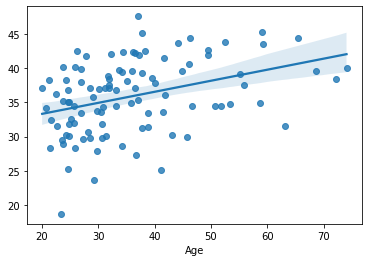

In [181]:
#load data
df_full = pd.read_csv("https://raw.githubusercontent.com/pni-lab/predmod_lecture/master/ex_data/IXI/ixi.csv")

# select a subset for cross-validation
df_cv = df_full.loc[:100, :]
# select an independent subset for searching for the k best features
df_ext = df_full.loc[100:200, :]

# names of the columns to be used
target = 'Age'
features = df_cv.columns[2:]

# select the 5 best features based on an independent sample
k_best_selector = SelectKBest(k=5).fit(y=df_ext[target], X=df_ext[features])
# then we choose these 5 features from the training set (without looking at the target in the training set)
k_best_features = k_best_selector.transform(df_cv[features])
# cross validation
cv = KFold(5) # 5 folds, 20 participants in each fold

cv_predictions = cross_val_predict(estimator=LinearRegression(), y=df_cv[target], X=k_best_features, cv=KFold(5))
sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')


Apparently, this results in a large improvement of cross-validated predictive performance, as compared to the example in the previous chapter, comprising all features.

:::{note}
Take a look at how scikit-learn's `SelectKBest` feature selector is used. By calling the `fit` function, it selects the best features from the external independnet dataset and the calling the fitted selector's `transform` function, it applies what it has "learned" from the extarnal dataset, i.e. chooses the "best features".
The `fit`, `tarnsform`, and `fit_transform` (doing both operations on the same data) functions are central in scikit-learn, most of its functionality can be accessed trough these functions. Separating the learning process (`fit`) and the application of the learned knowledge (`transform`) always allows a clean separation of training and test datasets. We will see numerous examples to the usage of this scheme in the followings.
:::

:::{admonition} Exercise 4.1
:class: tip, dropdown
How much is the improvement exactly? Compare the above results to [the case](../3_cross_validation/cv.ipynb) where we use all available features.
:::

:::{admonition} Exercise 4.2
:class: tip, dropdown
Try out different number of features. How does the cross-validated performance change?
:::

:::{admonition} Exercise 4.3
:class: tip, dropdown
Why do we have to use an *independent* dataset to select the k best features?
The answer is to be found in the [next section](leakage.ipynb).
:::

Despite the improvement, intuitively, you might feel that we have thrown out some information of the window, as we might have included variables that - even tough weaker - but still significantly predict the target.

This issue can be tackled by converting the original features into new 'latent' variables, which contain the same information, but in a potentially more useful form.
That's what PCA and PLS do!

## Dimensionality Reduction: PCA and PLS

As discussed in the [theory section](theory_regularization.ipynb), with PCA we can transform our features into 'latent' variables that are possibly more useful than the original ones. With PCA, the "essence" of a group of highly correlated features is "condensed down" into a single variable. Thus, taking the principal components as predictive features often allows decreasing the complexity of the model to a higher degree, as fewer PCA variables will be able to provide the same explanatory power as a larger number of original features.

Let's see it in practice! Below, we take the first five principal components calculated from all features.

MAE =  8.658108451519261 years


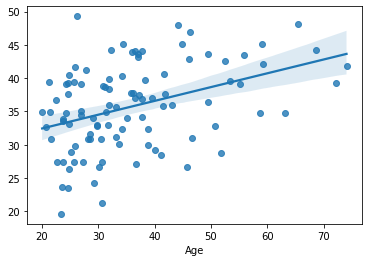

In [182]:
from sklearn.decomposition import PCA

features = df_cv.columns[2:]

pca = PCA(n_components=5)
pca_features = pca.fit_transform(df_cv[features])

# same as in the previous example except:                                          VVV here VVV
cv_predictions = cross_val_predict(estimator=LinearRegression(), y=df_cv[target], X=pca_features, cv=KFold(5))
sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

Again a small improvement. And this time we didn't have to use the independent external dataset, as - unlike `SelectKBest` - `PCA` does not incorporate any information about the target variable, only looks at the features.

Let's look at PLS!

MAE =  8.190707243962333 years


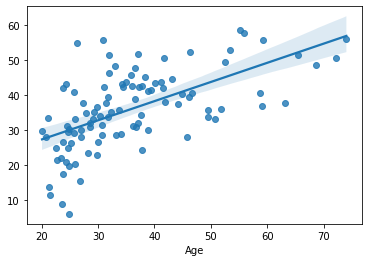

In [183]:
from sklearn.cross_decomposition import PLSRegression

# same as in the previous example except:            VVV here VVV
cv_predictions = cross_val_predict(estimator=PLSRegression(n_components=5), y=df_cv[target], X=df_cv[features], cv=KFold(5))
sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

Performance slightly improved again. Note that in this case the dimensionality reduction and fitting the regression model happens in on e step, in `PLSRegression`.
Indeed, the power of PLS lies in tailoring the dimensionality reduction to the characteristics of the target variable.

Looks like with PCA and PLS we have a performance gain, as compared to using the original features. But do we also loose something?
Yes, interpretability. Checking out the next exercise may shed some light on this. More details will be given in [chapter 7 "Model Explanation"](../7_model_explanation/index.md)

:::{admonition} Exercise 4.4
:class: tip, dropdown
Which regions were included in the prediction in case of SelectKBest (first example)? Printout their names!
Can you do the same with PCA or PLS?
:::

## Regularized models: Ridge and LASSO

Exercise 4.4 illustrates that transforming our original features to latent variables may have some disadvantages in terms of interpretability.
Let's look at how regularized regression models can reduce model complexity (and, thereby, fight overfitting), but at the same time, retain all the original variables.

MAE =  8.00562203685471 years


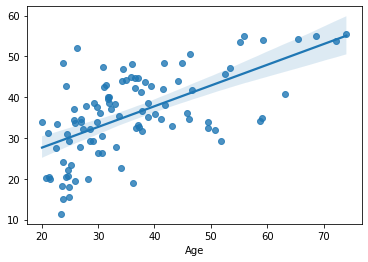

In [184]:
from sklearn.linear_model import Ridge

# we taka all features
features = df_cv.columns[2:]

# Changed:                                       VVV here VVV
cv_predictions = cross_val_predict(estimator=Ridge(alpha=10000000), y=df_cv[target], X=df_cv[features], cv=KFold(5))
sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

MAE =  8.028189984232535 years


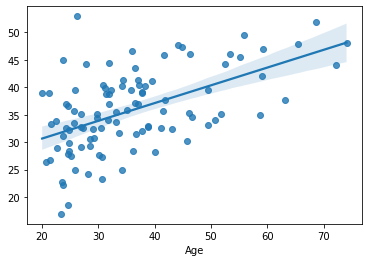

In [185]:
from sklearn.linear_model import Lasso

features = df_cv.columns[2:]

# Changed:                                     VVV here VVV
cv_predictions = cross_val_predict(estimator=Lasso(alpha=1000), y=df_cv[target], X=df_cv[features], cv=KFold(5))
sns.regplot(x=df_cv[target], y=cv_predictions)
print('MAE = ', mean_absolute_error(y_true=df_cv[target], y_pred=cv_predictions), 'years')

Both Ride and LASSO seem to be able to provide a predictive performance that is comparable (even slightly better), than using the dimension reduction-based approaches.

:::{admonition} Exercise 4.5
:class: tip, dropdown
How would other values of the alpha hyperparameter perform? Try it out!
:::

Curious, which regions are driving the prediction?
Then we will now have a sneak-preview into model interpretation, which will be discussed in detail in [chapter 7](../7_model_explanation/index.md)

Remember that Ridge and LASSO are just linear models with some extra steps.
So we can simply obtain the model coefficients ($\boldsymbol{b}$).
As the model's prediction is just a weighted average of the feature values, where the weights are the model's coefficients, the coefficients themselves can be considered as  a kind of 'feature importance': the degree to which that feature influences the predictions.

But there's a problem: in case of cross-validation we have actually multiple model.

Therefore, we must [finalize](../3_cross_validation/cv.ipynb) the model first.
Here we finalize our Ridge model by training it on the whole sample (without cv):

In [186]:
model = Ridge(alpha=1000)
model.fit(y=df_cv[target], X=df_cv[features])

Ridge(alpha=1000)

And then, we can simply print out the coefficients, together with the names of the features.

In [187]:
pd.DataFrame([model.coef_], columns=features).T

,0
lh_bankssts_volume,0.000092
lh_caudalanteriorcingulate_volume,-0.001514
lh_caudalmiddlefrontal_volume,-0.001669
lh_cuneus_volume,-0.003873
lh_entorhinal_volume,-0.000299
...,...
rh_supramarginal_volume,0.002263
rh_frontalpole_volume,-0.007186
rh_temporalpole_volume,0.006122
rh_transversetemporal_volume,-0.006611


With a few lines of code, we can visualize feature importance in 3D, to show the most important predictors of brain age:

:::{admonition} Exercise 4.6
:class: tip, dropdown
A little python exercise: sort the above list to see the regions with the smallest, largest coefficient.
Tip: look up the [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) documentation!
All you need is to add: `.sort_values(by=0)`
:::

:::{admonition} Exercise 4.7
:class: tip, dropdown
Sort the list of regions by the absolute value of their importance, to see the most important predictors in this model, regardless of the sign of the association with age.
:::

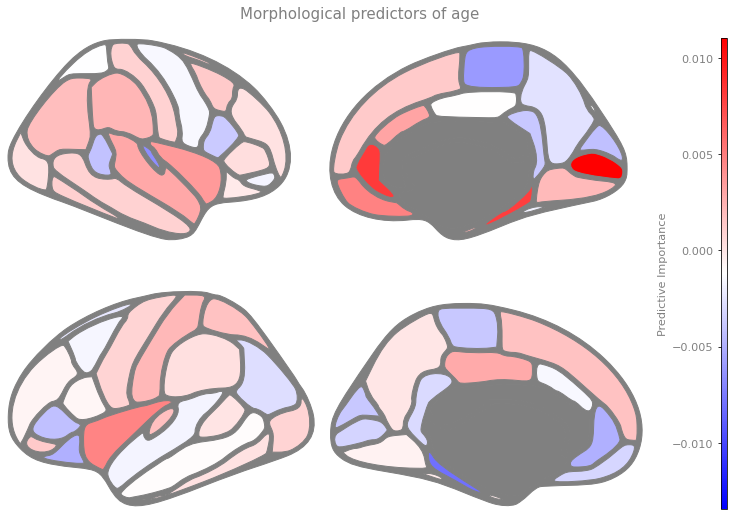

In [188]:
!pip install ggseg > /dev/null 2>&1
import ggseg
features_plot = features.values.copy()
# convert labels:
for i, f in enumerate(features):
    parts = f.split('_')
    if parts[0] == 'rh':
        parts[0] = 'right'
    else:
        parts[0] = 'left'
    features_plot[i] = parts[1] + '_' + parts[0]

ggseg.plot_dk(dict(zip(features_plot, model.coef_)), cmap='bwr', figsize=(10,10),
              background='w', edgecolor='gray', bordercolor='gray',
              ylabel='Predictive Importance', title='Morphological predictors of age')

:::{admonition} Exercise 4.8
:class: tip, dropdown
Finalize the LASSO model, too, and print and plot the coefficients.
What is the main difference?
:::

:::{admonition} Exercise 4.9
:class: tip, dropdown
Load in your own dataset and see how these machine learning models work on that.
:::

To recap, being able to control the complexity can drastically reduce the complexity of the model and thereby significantly improve predictive performance on unseen data.
The complexity of machine learning models can usually be set via one or more hyperparameters.

But how should we find the optimal values for the hyperparameters?
Should we simply do it in a trial and error fashion? Or should we systematically search for the value with which the cross-validated prediction look best?

Definitely not! To understand the reason why, we must get to know the second villain of machine learning: leakage!
